# 第11回講義 演習

In [1]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.transform
from keras.applications.vgg16 import VGG16
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1234)
random_state = 42

Using TensorFlow backend.


## 課題2. Attentionを用いたキャプション生成モデルの実装

### 1. データセットの読み込みと概観

Microsoft Common Objects in Context (MS COCO)という, 画像・キャプション・セグメンテーションなどがペアになったデータセットを使用します.

画像とキャプションのペアは全部で約8万3000件ありますが, 今回は計算時間やメモリ使用量などの観点から10000ペアに絞って使用します.

前処理済みのデータがaws上にあるので, それをダウンロードして使います.

- MS COCO: http://mscoco.org/

In [2]:
# %%bash # 一度だけ実行してください
# wget -q https://s3.amazonaws.com/ilect-public/ail/mscoco_captions_10000.txt # キャプションデータ
# wget -q https://s3.amazonaws.com/ilect-public/ail/mscoco_images_10000.npy # 画像データ

bash: #: No such file or directory


#### 1.1. 読み込み

In [3]:
def build_vocab(file_path, target):
    vocab = set()
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()
        vocab.update(words)

    if target:
        w2i = {w: np.int32(i+2) for i, w in enumerate(vocab)}
        w2i['<s>'], w2i['</s>'] = np.int32(0), np.int32(1) # 文の先頭・終端記号
    else:
        w2i = {w: np.int32(i) for i, w in enumerate(vocab)}

    return w2i

def encode(sentence, w2i):
    encoded_sentence = []
    for w in sentence:
        encoded_sentence.append(w2i[w])
    return encoded_sentence

def load_data(file_path, vocab=None, w2i=None, target=True):
    if vocab is None and w2i is None:
        w2i = build_vocab(file_path, target)
    
    data = []
    for line in open(file_path, encoding='utf-8'):
        s = line.strip().split()
        if target:
            s = ['<s>'] + s + ['</s>']
        enc = encode(s, w2i)
        data.append(enc)
    i2w = {i: w for w, i in w2i.items()}
    return data, w2i, i2w

In [4]:
train_y, w2i, i2w = load_data('./mscoco_captions_10000.txt', target=True)
train_X = np.load('./mscoco_images_10000.npy')

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.1)

今回はencoderの入力は画像でサイズは固定なので, decoderの入力$y$でソートします.

In [5]:
train_y_lens = [len(com) for com in train_y]
valid_y_lens = [len(com) for com in valid_y]
sorted_train_indexes = sorted(range(len(train_y_lens)), key=lambda x: -train_y_lens[x])
sorted_valid_indexes = sorted(range(len(valid_y_lens)), key=lambda x: -valid_y_lens[x])

train_X = [train_X[ind] for ind in sorted_train_indexes]
train_y = [train_y[ind] for ind in sorted_train_indexes]
valid_X = [valid_X[ind] for ind in sorted_valid_indexes]
valid_y = [valid_y[ind] for ind in sorted_valid_indexes]

#### 1.2. データセットの中身

a room shows a twin bed , crib , double bed , and a round bed , all featuring checks and pillows , either white , or checked , high windows , a brick wall , a piece of art against a white wall , and a separate vertical surface with framed items on it .


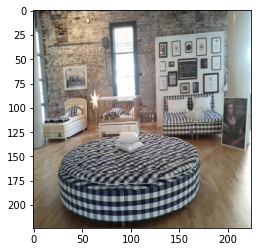

In [6]:
num = 0

print(' '.join([i2w[com] for com in train_y[num][1:-1]]))
plt.imshow(train_X[num])

### 2. 各層クラスの実装

次のモデルを実装します.

<img src="attention-2.png" size="1000mm">

まず224x224x3の画像をEncoder (CNN) で特徴量マップ$u$に落とし込み, それを元にDecoder (LSTM + Attention) でキャプションを生成していきます.

#### 2.1. Encoder

まずCNNに必要なクラスを実装していきます. これらはchap8で用いたものと同じです.

今回は, CNNは学習済みのモデルを使います. これは`Keras.applications`から読み込むことができます. Convクラスでは学習済みの重みを`tf.Variable`の初期値とするために, コンストラクタの引数に初期値を取れるよう書いています.

また, `tf.Variable`の`trainable`オプションを`False`にすることで, パラメータの更新をしないようにしています.

In [7]:
class Conv:
    def __init__(self, filter_shape, W, b, function=lambda x: x, strides=[1,1,1,1], padding='VALID'):
        # Xavier
        fan_in = np.prod(filter_shape[:3])
        fan_out = np.prod(filter_shape[:2]) * filter_shape[3]
        self.W = tf.Variable(W, trainable=False, name='W')
        self.b = tf.Variable(b, trainable=False, name='b')
        self.function = function
        self.strides = strides
        self.padding = padding

    def f_prop(self, x):
        conv_out = tf.nn.conv2d(x, self.W, strides=self.strides, padding=self.padding)
        return self.function(tf.nn.bias_add(conv_out, self.b)) # broadcasting

In [8]:
class Pooling:
    def __init__(self, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
    
    def f_prop(self, x):
        return tf.nn.max_pool(x, ksize=self.ksize, strides=self.strides, padding=self.padding)

In [9]:
# 入力xが行列([batch_size, hid_dim])の全結合層
class Dense2d:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)

#### 2.2. Decoder

次にDecoderのためのクラスを設定していきます. Embedding, Dense層はChap10で用いたものと同じです. LSTM層はmaskがない所以外は同じです. (LSTMはDecoderでのみ使うので, maskは必要ないです)

In [10]:
class Embedding:
    def __init__(self, vocab_size, emb_dim, scale=0.08):
        self.V = tf.Variable(rng.randn(vocab_size, emb_dim).astype('float32') * scale, name='V')

    def f_prop(self, x):
        return tf.nn.embedding_lookup(self.V, x)
    
    def f_prop_test(self, x_t):
        return tf.nn.embedding_lookup(self.V, x_t)

In [11]:
class LSTM:
    def __init__(self, in_dim, hid_dim, h_0=None, c_0=None):
        self.in_dim = in_dim
        self.hid_dim = hid_dim

        # input gate
        self.W_xi = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xi')
        self.W_hi = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hi')
        self.b_i  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_i')
        
        # forget gate
        self.W_xf = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
        self.W_hf = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hf')
        self.b_f  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_f')
        
        # cell state
        self.W_xc = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xc')
        self.W_hc = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hc')
        self.b_c  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_c')
        
        # output gate
        self.W_xo = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xo')
        self.W_ho = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_ho')
        self.b_o  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_o')

        # initial state
        self.h_0 = h_0
        self.c_0 = c_0

    def f_prop(self, x):
        def fn(tm1, x_t):
            h_tm1 = tm1[0]
            c_tm1 = tm1[1]
            # input gate
            i_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xi) + tf.matmul(h_tm1, self.W_hi) + self.b_i)

            # forget gate
            f_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xf) + tf.matmul(h_tm1, self.W_hf) + self.b_f)

            # cell state
            c_t = f_t * c_tm1 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(h_tm1, self.W_hc) + self.b_c)

            # output gate
            o_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xo) + tf.matmul(h_tm1, self.W_ho) + self.b_o)

            # hidden state
            h_t = o_t * tf.nn.tanh(c_t)

            return [h_t, c_t]

        _x = tf.transpose(x, perm=[1, 0, 2])

        if self.h_0 == None:
            self.h_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))
        if self.c_0 == None:
            self.c_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))

        h, c = tf.scan(fn=fn, elems=_x, initializer=[self.h_0, self.c_0])
        return tf.transpose(h, perm=[1, 0, 2]), tf.transpose(c, perm=[1, 0, 2])

    def f_prop_test(self, x_t):
        # input gate
        i_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xi) + tf.matmul(self.h_0, self.W_hi) + self.b_i)

        # forget gate
        f_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xf) + tf.matmul(self.h_0, self.W_hf) + self.b_f)

        # output gate
        o_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xo) + tf.matmul(self.h_0, self.W_ho) + self.b_o)

        # cell state
        c_t = f_t * self.c_0 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(self.h_0, self.W_hc) + self.b_c)

        # hidden state
        h_t = o_t * tf.nn.tanh(c_t)

        return [h_t, c_t]

In [12]:
# 入力xが3階テンソル([batch_size, sentence_length, hid_dim])の全結合層
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(tf.zeros([out_dim], dtype=tf.float32), name='b')
        self.function = function

    def f_prop(self, x):
        return self.function(tf.einsum('ijk,kl->ijl', x, self.W) + self.b)

    def f_prop_test(self, x_t):
        return self.function(tf.matmul(x_t, self.W) + self.b)

#### Attention層

簡単のため, attention層は翻訳で用いたものとほぼ同じものを使用します. 違いとして, 翻訳ではmaskを設定しましたが, 今回はEncoderの出力は固定長なのでmaskは必要ないです.

「入力のどこに注目するか」は, 翻訳ではEncoderの各ステップの隠れ層でしたが, キャプション生成ではCNNで獲得したサイズ14x14の特徴量マップに対しておこないます. 14x14のままでは扱いにくいので, 長さ196 (=14x14) のベクトルにflattenしてから処理します.

今回の演習では細かい部分は省略していますが, 実際のアテンション付きキャプション生成の論文ではさらに,
- attention層で計算した文脈ベクトルをLSTMにfeedしている
- 出力層での計算にも単語の埋め込みベクトルを用いている
- Encoderに19層のVGGをつかっている.

などとしています. 詳細は論文を参照してください.
- "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention", Kelvin Xu et al., ICML 2015 https://arxiv.org/abs/1502.03044

In [13]:
class Attention:
    def __init__(self, cnn_dim, rnn_dim, out_dim, u):
        self.W_cc = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=[cnn_dim, out_dim]).astype('float32'), name='W_cc')
        self.W_ch = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=[rnn_dim, out_dim]).astype('float32'), name='W_ch')
        self.W_a = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=[cnn_dim, rnn_dim]).astype('float32'), name='W_a')
        self.b = tf.Variable(np.zeros(out_dim).astype('float32'), name='b')
        self.u = u

    def f_prop(self, h_dec):
        u = tf.einsum('ijk,kl->ijl', self.u, self.W_a) # featuremap flatten
        score = tf.einsum('ijk,ilk->ijl', h_dec, u) # Attention score
        self.a = tf.nn.softmax(score) # Attention weight
        c = tf.einsum('ijk,ikl->ijl', self.a, self.u) # Context vector
        return tf.nn.tanh(tf.einsum('ijk,kl->ijl', c, self.W_cc) + tf.einsum('ijk,kl->ijl', h_dec, self.W_ch) + self.b)

    def f_prop_test(self, h_dec_t):
        u = tf.einsum('ijk,kl->ijl', self.u, self.W_a)
        score = tf.einsum('ij,ikj->ik', h_dec_t, u) # Attention score
        self.a = tf.nn.softmax(score) # Attention weight
        c = tf.einsum('ij,ijk->ik', self.a, self.u) # Context vector
        return tf.nn.tanh(tf.matmul(c, self.W_cc) + tf.matmul(h_dec_t, self.W_ch) + self.b)

### 4. 計算グラフの構築 & パラメータの更新設定

#### 4.1. Pre-trained modelの読み込み

CNNは16層のVGGネットワークを使います. また, Kerasに訓練済みのモデルがあるので, そちらをloadし重みを取得して, `tf.Variable`の初期値として使います.

- "Very Deep Convolutional Networks for Large-Scale Image Recognition", Karen Simonyan et al., ICLR 2015 https://arxiv.org/abs/1409.1556
- Keras Applications: https://keras.io/applications/

In [14]:
model = VGG16()

weights = [com.get_weights() for com in model.layers[1:]] # 各層の重み(W, b)を取得.

#### 4.2. グラフの構築

In [15]:
import sys

vocab_size = len(i2w)
emb_dim = 64
rnn_dim = 64
att_dim = 64
hid_dim = 64
mlp_dim = 64
cnn_dim = 512

x = tf.placeholder(tf.float32, [None, 224, 224, 3])
d = tf.placeholder(tf.int32, [None, None], name='d')
d_in = d[:, :-1]
d_out = d[:, 1:]
d_out_one_hot = tf.one_hot(d_out, depth=vocab_size, dtype=tf.float32)


# 16-layer VGG
cnn_layers = [
    Conv((3, 3, 3, 64), weights[0][0], weights[0][1], tf.nn.relu, padding='SAME'), # 224x224x3 -> 224x224x64
    Conv((3, 3, 64, 64), weights[1][0], weights[1][1], tf.nn.relu, padding='SAME'), # 224x224x64 -> 224x224x64
    Pooling((1, 2, 2, 1)), # 224x224x64 -> 112x112x64
    Conv((3, 3, 64, 128), weights[3][0], weights[3][1], tf.nn.relu, padding='SAME'), # 112x112x64 -> 112x112x128
    Conv((3, 3, 128, 128), weights[4][0], weights[4][1], tf.nn.relu, padding='SAME'), # 112x112x128 -> 112x112x128
    Pooling((1, 2, 2, 1)), # 112x112x128 -> 56x56x128
    Conv((3, 3, 128, 256), weights[6][0], weights[6][1], tf.nn.relu, padding='SAME'), # 56x56x128 -> 56x56x256
    Conv((3, 3, 256, 256), weights[7][0], weights[7][1], tf.nn.relu, padding='SAME'), # 56x56x256 -> 56x56x256
    Conv((3, 3, 256, 256), weights[8][0], weights[8][1], tf.nn.relu, padding='SAME'), # 56x56x256 -> 56x56x256
    Pooling((1, 2, 2, 1)), # 56x56x256 -> 28x28x256
    Conv((3, 3, 256, 512), weights[10][0], weights[10][1], tf.nn.relu, padding='SAME'), # 28x28x256 -> 28x28x512
    Conv((3, 3, 512, 512), weights[11][0], weights[11][1], tf.nn.relu, padding='SAME'), # 28x28x512 -> 28x28x512
    Conv((3, 3, 512, 512), weights[12][0], weights[12][1], tf.nn.relu, padding='SAME'), # 28x28x512 -> 28x28x512
    Pooling((1, 2, 2, 1)), # 28x28x512 -> 14x14x512
    Conv((3, 3, 512, 512), weights[14][0], weights[14][1], tf.nn.relu, padding='SAME'), # 14x14x512 -> 14x14x512
    Conv((3, 3, 512, 512), weights[15][0], weights[15][1], tf.nn.relu, padding='SAME'), # 14x14x512 -> 14x14x512
    Conv((3, 3, 512, 512), weights[16][0], weights[16][1], tf.nn.relu, padding='SAME'), # 14x14x512 -> 14x14x512
]

def f_props(layers, x):
    for layer in layers:
        x = layer.f_prop(x)
    return x

u_ = f_props(cnn_layers, x)
u = tf.reshape(u_, [-1, 196, 512]) # 14x14x512 -> 196x512

u_mean = tf.reduce_mean(u, axis=1)

# LSTMのセルの初期値を獲得するネットワーク
mlp_layers_c = [
    Dense2d(512, rnn_dim, tf.nn.tanh),
]

# LSTMの隠れ層ベクトルの初期値を獲得するネットワーク
mlp_layers_h = [
    Dense2d(512, rnn_dim, tf.nn.tanh),
]

c_init = f_props(mlp_layers_c, u_mean) # LSTMのセルの初期値
h_init = f_props(mlp_layers_h, u_mean) # LSTMの隠れ層ベクトルの初期値

decoder_pre = [
    Embedding(vocab_size, emb_dim),
    LSTM(emb_dim, hid_dim, h_init, c_init)
]

decoder_post = [
    Attention(cnn_dim, rnn_dim, hid_dim, u),
    Dense(hid_dim, vocab_size, tf.nn.softmax)
]

h_dec, c_dec = f_props(decoder_pre, d_in)
y = f_props(decoder_post, h_dec)

cost = -tf.reduce_mean(tf.reduce_sum(d_out_one_hot * tf.log(tf.clip_by_value(y, 1e-10, 1.0)), axis=[1,2]))

train = tf.train.AdamOptimizer().minimize(cost)

### 5. 学習

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 10
batch_size = 32
n_batches_train = len(train_X)//batch_size
n_batches_valid = len(valid_X)//batch_size

sess.run(tf.global_variables_initializer())
for epoch in range(n_epochs):
    # Train
    train_costs = []
    for i in range(n_batches_train):
        start = i * batch_size
        end = start + batch_size

        train_X_mb = train_X[start:end]
        train_y_mb = np.array(pad_sequences(train_y[start:end], padding='post', value=-1))
        
        _, train_cost = sess.run([train, cost], feed_dict={x: train_X_mb, d: train_y_mb})

        train_costs.append(train_cost)

    # Valid
    valid_costs = []
    for i in range(n_batches_valid):
        start = i * batch_size
        end = start + batch_size
        
        valid_X_mb = np.array(valid_X[start:end])
        valid_y_mb = np.array(pad_sequences(valid_y[start:end], padding='post', value=-1))
        
        valid_cost = sess.run(cost, feed_dict={x: valid_X_mb, d: valid_y_mb})
        
        valid_costs.append(valid_cost)

    print('EPOCH: %i, Training cost: %.3f, Validation cost: %.3f' % (epoch+1, np.mean(train_costs), np.mean(valid_costs)))

EPOCH: 1, Training cost: 68.386, Validation cost: 64.730
EPOCH: 2, Training cost: 60.452, Validation cost: 61.128
EPOCH: 3, Training cost: 56.603, Validation cost: 58.319
EPOCH: 4, Training cost: 52.803, Validation cost: 57.923
EPOCH: 5, Training cost: 50.906, Validation cost: 55.857
EPOCH: 6, Training cost: 49.662, Validation cost: 54.857
EPOCH: 7, Training cost: 48.577, Validation cost: 54.420
EPOCH: 8, Training cost: 47.629, Validation cost: 54.072
EPOCH: 9, Training cost: 46.812, Validation cost: 52.850
EPOCH: 10, Training cost: 45.900, Validation cost: 53.175


### 6. キャプションの生成と Attention weight の可視化

#### 6.1. グラフの構築

In [17]:
t_0 = tf.constant(0)
h_0 = tf.placeholder(tf.float32, [None, None], name='h_0')
c_0 = tf.placeholder(tf.float32, [None, None], name='c_0')
y_0 = tf.placeholder(tf.int32, [None, None], name='y_0')
a_0 = tf.zeros_like(decoder_post[0].u[:, :, :1], dtype=tf.float32, name='a_0')
f_0 = tf.cast(tf.zeros_like(y_0[:, 0]), dtype=tf.bool) # バッチ内の各サンプルに対して</s>が出たかどうかのflag

f_0_size = tf.reduce_sum(tf.ones_like(f_0, dtype=tf.int32))
max_len = tf.placeholder(tf.int32, name='max_len') # iterationの繰り返し回数の限度

def f_props_test(layers, x_t):
    for layer in layers:
        x_t = layer.f_prop_test(x_t)
    return x_t

def cond(t, h_t, c_t, y_t, a_t, f_t):
    num_true = tf.reduce_sum(tf.cast(f_t, tf.int32)) # Trueの数
    unfinished = tf.not_equal(num_true, f_0_size)
    return tf.logical_and(t+1 < max_len, unfinished)

def body(t, h_tm1, c_tm1, y, a, f_tm1):
    y_tm1 = y[:, -1]

    decoder_pre[1].h_0 = h_tm1
    decoder_pre[1].c_0 = c_tm1
    h_t, c_t = f_props_test(decoder_pre, y_tm1)
    y_t = tf.cast(tf.argmax(f_props_test(decoder_post, h_t), axis=1), tf.int32)
    a_t = decoder_post[0].a
    
    y = tf.concat([y, y_t[:, np.newaxis]], axis=1)
    a = tf.concat([a, a_t[:, :, np.newaxis]], axis=2)
    
    f_t = tf.logical_or(f_tm1, tf.equal(y_t, 1))
    
    return [t+1, h_t, c_t, y, a, f_t]

res = tf.while_loop(
    cond,
    body,
    loop_vars=[t_0, h_0, c_0, y_0, a_0, f_0],
    shape_invariants=[
        t_0.get_shape(),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None, None]),
        tf.TensorShape([None])
    ]
)

#### 6.2. 生成

In [18]:
valid_X_mb = np.array(valid_X[0:32])
_y_0 = np.zeros([len(valid_X[0:32]), 1], dtype='int32')

_h_0, _c_0, _u = sess.run([h_init, c_init, u], feed_dict={x: valid_X_mb})

_, _, _, pred_y, att_weights, _ = sess.run(res, feed_dict={
    decoder_post[0].u: _u,
    y_0: _y_0,
    h_0: _h_0,
    c_0: _c_0,
    max_len: 100
})

#### 6.3. アテンションの可視化

In [19]:
num = 0

truex = valid_X[num]
predy = pred_y[num].tolist()[1:pred_y[num].tolist().index(1)]
truey = valid_y[num][1:-1]
aa = att_weights[num][:, 1:len(predy)+1].T

画像

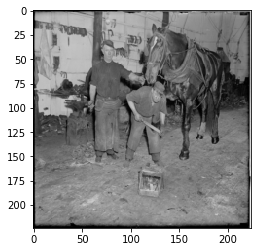

In [20]:
plt.imshow(truex)

生成されたキャプションと正解キャプション

In [21]:
print('生成文されたキャプション:', ' '.join([i2w[com] for com in predy]))
print('正解キャプション:', ' '.join([i2w[com] for com in truey]))

生成文されたキャプション: a man in a street on a street
正解キャプション: black and white of a blacksmith interior with a horse , a man standing with arm out to it , and a man ducking under it 's head and holding a long metal file in both hands , with horses on poles on the wall .


アテンションの可視化

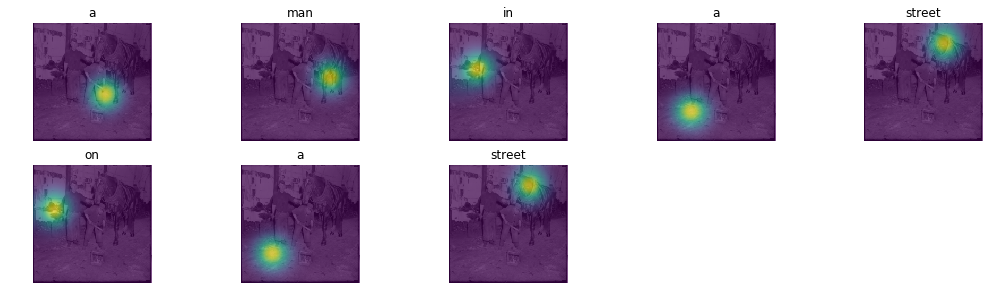

In [22]:
fig = plt.figure(figsize=(18, 10))

for i, (word, a) in enumerate(zip(predy, aa)):
    ax = fig.add_subplot(4, 5, i+1)
    
    # Plot image
    ax.imshow(truex)
    ax.axis('off')
    
    # Plot attention
    a = skimage.transform.pyramid_expand(a.reshape(14, 14), upscale=16, sigma=20)
    ax.imshow(a, alpha=.65)
    
    # Plot word
    ax.set_title(i2w[word])
plt.show()